<a href="https://colab.research.google.com/github/Harshinikavuru/911_project/blob/main/final_linking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 18.5 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13572173 sha256=cb30e2a6237d399719d69236cf265f1f10914fe70dc36d97048cccf59c99f72b
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Un

In [2]:
import scispacy
import spacy
import joblib
import re
import string

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
import re
from nltk import word_tokenize
from collections import Counter
from tqdm import tqdm
from collections import defaultdict

In [3]:
data = pd.read_csv("/content/df_sure_april26.csv")

In [4]:
model = spacy.load("en_ner_bc5cdr_md")

In [5]:
unique_categories_num = data['nature'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_categories_num.index, 'Count': unique_categories_num.values})
counts_df_full

,Category,Count
0,SICK PERSON,126
1,INJURED FROM A FALL,93
2,Sick Person,57
3,LIFT ASSIST,50
4,DIFFICULTY BREATHING,44
...,...,...
148,DISABLED VEHICLE,1
149,Fire-Odor Investigation,1
150,FIRE - MULCH,1
151,FIRE - BARN,1


In [6]:
data['nature'] = data['nature'].str.lower()

In [7]:
unique_categories_num = data['nature'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_categories_num.index, 'Count': unique_categories_num.values})
counts_df_full

,Category,Count
0,sick person,183
1,injured from a fall,129
2,lift assist,84
3,difficulty breathing,68
4,chest pain,63
...,...,...
115,fire - mulch,1
116,request for a k-9,1
117,fire - barn,1
118,animal bite,1


In [8]:
data['New Category'] = data['nature'].apply(lambda x: 'Fire' if 'fire' in x.lower() else ('cardiac_arrest' if 'cardiac' in x.lower() else ('heart_attack' if 'heart' in x.lower() else x)))

In [9]:
data['New Category'] = data['New Category'].apply(lambda x: 'heart_attack' if 'chest pain' in x.lower() else x)

In [10]:
data['New Category'] = data['New Category'].apply(lambda x: 'stroke' if 'stroke' in x.lower() else x)

In [11]:
data['New Category'] = data['New Category'].apply(lambda x: 'Major_trauma' if 'injured' in x.lower() else x)

In [12]:
data['New Category'] = data['New Category'].apply(lambda x: 'Major_trauma' if 'injury' in x.lower() else x)

In [13]:
data['New Category'] = data['New Category'].apply(lambda x: 'seizure' if 'convulsion/seizures' in x.lower() else x)

In [14]:
data['New Category'] = data['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose / poisoning' in x.lower() else x)

In [15]:
data['New Category'] = data['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose - poisoning' in x.lower() else x)

In [16]:
data['New Category'] = data['New Category'].apply(lambda x: 'difficulty breathing' if 'choking' in x.lower() else x)

In [17]:
data['New Category'] = data['New Category'].apply(lambda x: 'Major_trauma' if 'fall' in x.lower() else x)

In [18]:
data['New Category'] = data['New Category'].apply(lambda x: 'difficulty breathing' if 'overdose/poisoning' in x.lower() else x)

In [19]:
data['New Category'] = data['New Category'].apply(lambda x: '911 cellular hang-up/open/misdial' if '911 hang-up/open/misdial' in x.lower() else x)

In [20]:
data['New Category'] = data['New Category'].apply(lambda x: '911 cellular hang-up/open/misdial' if 'duplicate call' in x.lower() else x)

In [21]:
data['New Category'] = data['New Category'].apply(lambda x: 'suspicious person' if 'suspicious person/vehicle' in x.lower() else x)

In [22]:
data['New Category'] = data['New Category'].apply(lambda x: 'heart_attack' if 'cardiac_arrest' in x.lower() else x)

In [23]:
unique_categories_num = data['New Category'].value_counts()
counts_df_full = pd.DataFrame({'Category': unique_categories_num.index, 'Count': unique_categories_num.values})
counts_df_full

,Category,Count
0,sick person,183
1,Major_trauma,173
2,difficulty breathing,100
3,heart_attack,88
4,lift assist,84
...,...,...
74,juvenile runaway,1
75,suicide,1
76,assault,1
77,drug / narcotic,1


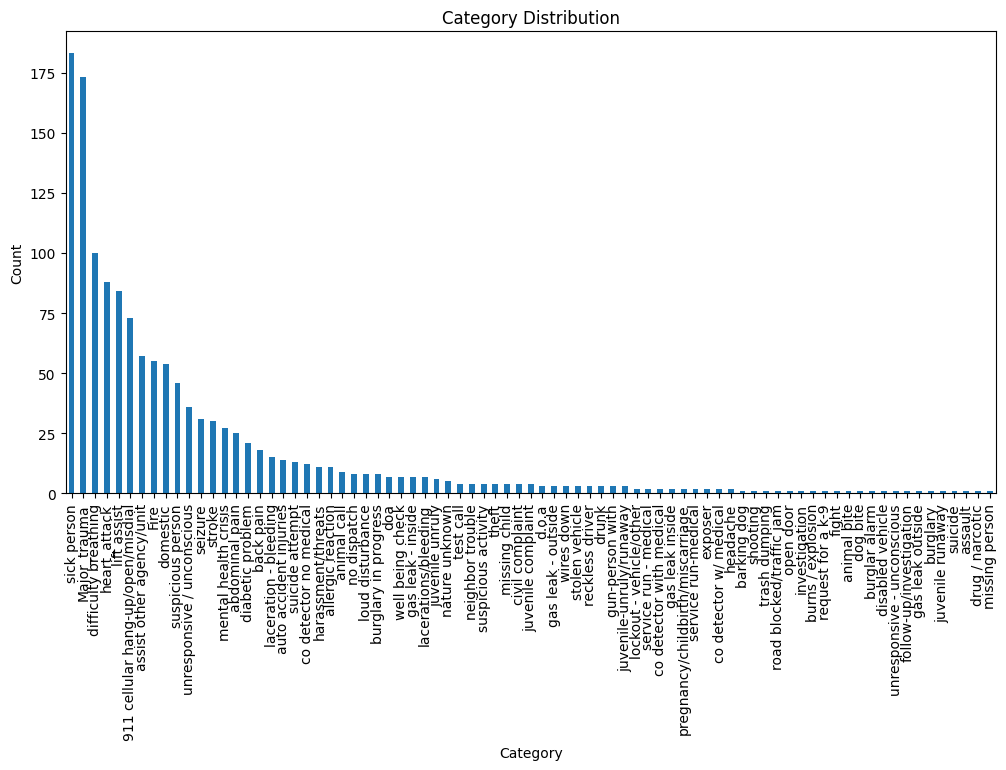

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [24]:
category_counts = data['New Category'].value_counts()
limit = 30
selected_categories = category_counts[category_counts > limit].index.tolist()
filtered_df = data.loc[data['New Category'].isin(selected_categories)]

In [25]:
selected_categories

['sick person',
 'Major_trauma',
 'difficulty breathing',
 'heart_attack',
 'lift assist',
 '911 cellular hang-up/open/misdial',
 'assist other agency/unit',
 'Fire',
 'domestic',
 'suspicious person',
 'unresponsive / unconscious',
 'seizure']

In [29]:
filtered_df

,Unnamed: 0,best_match_score,__id_left,__id_right,nature,incidentno,start,address,Date_left,AddressNumber_left,...,TEXT,Date_right,AddressNumber_right,PlaceName_right,StreetName_right,StreetNameSuffix_right,group,Result,dategroup,New Category
0,0,0.326598,28,16_right,chest pain,28,2021-01-01 01:08:09,317 CHELSEA ST DELAWARE,2021-01-01 00:00:00,317,...,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,2021-01-01 00:00:00,317,NaN,chelsea,st,0.3-0.4,2.326598,Sureconnection,heart_attack
1,334,0.350217,193,9_right,fire-commercial,193,2021-01-01 17:03:19,3971 BRADFORD CT LIBERTY TWP,2021-01-01 00:00:00,3971,...,"0012.5s 0014.7s SPEAKER_01: 911, what's the a...",2021-01-01 00:00:00,3971,NaN,bradford,ct,0.3-0.4,2.350217,Sureconnection,Fire
3,542,0.420300,199,33_right,sick person,199,2021-01-01 17:22:12,8681 KIRKLAND DR ORANGE TWP,2021-01-01 00:00:00,8681,...,"0011.1s 0012.9s SPEAKER_01: 911, let's addres...",2021-01-01 00:00:00,8681,NaN,kirkland,dr,0.4-0.5,2.420300,Sureconnection,sick person
4,543,0.087990,57,27_right,lift assist,57,2021-01-01 04:05:27,3790 S OLD 3C HWY GENOA TWP,2021-01-01 00:00:00,3790,...,0005.9s 0006.4s SPEAKER_00: now.\n 0009.6s 00...,2021-01-01 00:00:00,3790,NaN,old,NaN,0-0.1,2.087990,Sureconnection,lift assist
5,803,0.317291,454,49_right,lift assist,454,2021-01-02 15:13:30,116 W MOHAWK DR SHAWNEE HILLS,2021-01-02 00:00:00,116,...,"0011.0s 0014.2s SPEAKER_00: 911, what's he ad...",2021-01-02 00:00:00,116,NaN,mohawk,NaN,0.3-0.4,2.317291,Sureconnection,lift assist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,555672,0.118673,71390,4538_right,911 cellular hang-up/open/misdial,71390,2021-06-29 15:54:00,53 BIRCH ROW DELAWARE,2021-06-29 00:00:00,53,...,0004.1s 0004.7s SPEAKER_00: Thank you.\n 0009...,2021-06-29 00:00:00,53,NaN,burch,rd,0.1-0.2,2.118673,Sureconnection,911 cellular hang-up/open/misdial
1337,556518,0.032034,71930,4549_right,chest pain,71930,2021-06-30 20:53:00,9240 TODD STREET KINGSTON TWP,2021-06-30 00:00:00,9240,...,"0011.4s 0013.8s SPEAKER_02: 911, what is the ...",2021-06-30 00:00:00,8420,NaN,todd,st,0-0.1,2.032034,Sureconnection,heart_attack
1338,557357,0.143436,71839,4548_right,suspicious person,71839,2021-06-30 16:59:00,7319 SAWMILL POWELL,2021-06-30 00:00:00,7319,...,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",2021-06-30 00:00:00,7319,NaN,sawmill,pkwy,0.1-0.2,2.143436,Sureconnection,suspicious person
1339,557475,0.143436,71857,4548_right,injured person - basic,71857,2021-06-30 17:53:00,7319 SAWMILL POWELL,2021-06-30 00:00:00,7319,...,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",2021-06-30 00:00:00,7319,NaN,sawmill,pkwy,0.1-0.2,2.143436,Sureconnection,Major_trauma


In [30]:
df = pd.DataFrame(
    dict(
        text=filtered_df["TEXT"],
        target= filtered_df["New Category"]))

In [31]:
df

,text,target
0,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,heart_attack
1,"0012.5s 0014.7s SPEAKER_01: 911, what's the a...",Fire
3,"0011.1s 0012.9s SPEAKER_01: 911, let's addres...",sick person
4,0005.9s 0006.4s SPEAKER_00: now.\n 0009.6s 00...,lift assist
5,"0011.0s 0014.2s SPEAKER_00: 911, what's he ad...",lift assist
...,...,...
1336,0004.1s 0004.7s SPEAKER_00: Thank you.\n 0009...,911 cellular hang-up/open/misdial
1337,"0011.4s 0013.8s SPEAKER_02: 911, what is the ...",heart_attack
1338,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",suspicious person
1339,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",Major_trauma


In [32]:
unique_category_nums = df['target'].value_counts()

In [33]:
counts_df_full = pd.DataFrame({'Category': unique_category_nums.index, 'Count': unique_category_nums.values})
counts_df_full

,Category,Count
0,sick person,183
1,Major_trauma,173
2,difficulty breathing,100
3,heart_attack,88
4,lift assist,84
5,911 cellular hang-up/open/misdial,73
6,assist other agency/unit,57
7,Fire,55
8,domestic,54
9,suspicious person,46


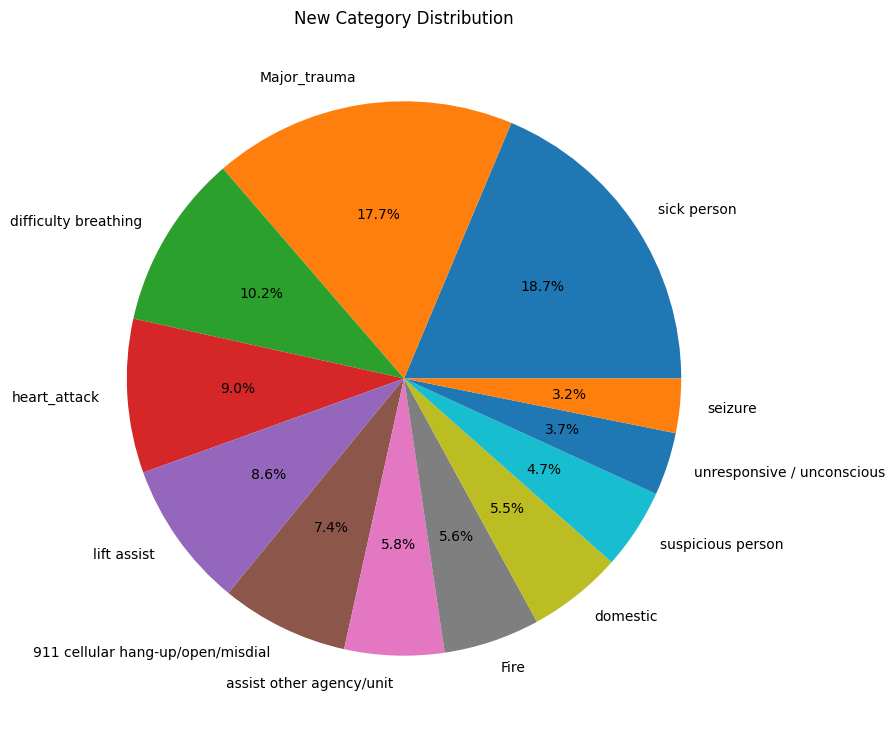

In [34]:
fig = plt.figure(figsize=(9, 9))
plt.pie(unique_category_nums.values, labels= unique_category_nums.index, autopct='%1.1f%%')
plt.title('New Category Distribution')
plt.show()

In [35]:
df['text'][0]

"0002.0s 0002.5s SPEAKER_01:  Umm\n 0003.3s 0006.7s SPEAKER_01:  I need you to do that for me now. I don't care, Tanya.\n 0006.4s 0010.8s SPEAKER_00:  Okay, I have your number at 740-971-8962, is that correct?\n 0011.1s 0011.5s SPEAKER_01:  Yeah.\n 0011.9s 0013.0s SPEAKER_00:  Okay, and what's your name?\n 0013.6s 0015.8s SPEAKER_01:  All in!\n 0014.6s 0014.9s SPEAKER_00:  KARGER!\n 0017.0s 0019.3s SPEAKER_00:  And you said, how old are you?\n 0018.6s 0020.5s SPEAKER_01:  how are you going to go to the car\n 0023.1s 0023.7s SPEAKER_00:  Howdy\n 0023.1s 0024.0s SPEAKER_01:  How are you, Kevin?\n 0024.4s 0025.0s SPEAKER_00:  27.\n 0025.6s 0025.9s SPEAKER_01:  K\n 0026.2s 0027.6s SPEAKER_00:  Are you still outside in the car?\n 0028.2s 0029.5s SPEAKER_01:  No, I didn't leave yet.\n 0030.2s 0036.2s SPEAKER_00:  Okay, yeah, we actually have medics coming to see you there at 317 Chelsea Street, Department D, okay? So you don't have to go anywhere.\n 0039.7s 0041.8s SPEAKER_00:  Okay, I'm jus

In [36]:
def remove_time_and_speaker(text):
  text = re.sub(r"\d+\.\ds \d+\.\ds SPEAKER_\d+","",text)
  return text
df["clean_text"] = df.text.map(remove_time_and_speaker)

In [37]:
def process_text(text):
    text = str(text).lower()
    text = " ".join(text.split())
    return text

df["clean_text"] = df.clean_text.map(process_text)

In [38]:
def unicodes_remove(text):
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text
df["clean_text"] = df.clean_text.map(unicodes_remove)


In [39]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in (stop)])
    return text
df["clean_text"] = df.clean_text.map(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
df

,text,target,clean_text
0,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,heart_attack,umm need dont care tanya okay number 740971896...
1,"0012.5s 0014.7s SPEAKER_01: 911, what's the a...",Fire,911 whats address emergency hi located forgot ...
3,"0011.1s 0012.9s SPEAKER_01: 911, let's addres...",sick person,911 lets address emergency yeah 8681 kirkland ...
4,0005.9s 0006.4s SPEAKER_00: now.\n 0009.6s 00...,lift assist,911 whats address emergency husband fallen can...
5,"0011.0s 0014.2s SPEAKER_00: 911, what's he ad...",lift assist,911 whats address emergency yes name mary gate...
...,...,...,...
1336,0004.1s 0004.7s SPEAKER_00: Thank you.\n 0009...,911 cellular hang-up/open/misdial,thank 911 would say emergency yes 53 burch roa...
1337,"0011.4s 0013.8s SPEAKER_02: 911, what is the ...",heart_attack,911 address emergency emergency 8420 todd stre...
1338,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",suspicious person,911 whats address emergency really emergency g...
1339,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",Major_trauma,911 whats address emergency really emergency g...


In [41]:
def keywords_extract(text):
  d=''
  for sent in [line.strip() for line in text.split(" ")]:
    doc = model(sent)
    for ent in doc.ents:
      if ent.label_=='CHEMICAL':
        d=d+(ent.text)
        d=d+' '
  d=d+'-'
  return (d)
df["key_words_chemical"] = df.clean_text.map(keywords_extract)

In [42]:
def keywords_extract_1(text):
  d=''
  for sent in [line.strip() for line in text.split(" ")]:
    doc = model(sent)
    for ent in doc.ents:
      if ent.label_=='DISEASE':
        d=d+(ent.text)
        d=d+' '
  d=d+'-'
  return (d)
df["key_words_disease"] = df.clean_text.map(keywords_extract_1)

In [43]:
df

,text,target,clean_text,key_words_chemical,key_words_disease
0,0002.0s 0002.5s SPEAKER_01: Umm\n 0003.3s 000...,heart_attack,umm need dont care tanya okay number 740971896...,-,pain pain -
1,"0012.5s 0014.7s SPEAKER_01: 911, what's the a...",Fire,911 whats address emergency hi located forgot ...,smelling smoke smoke smoke smoke smoke -,-
3,"0011.1s 0012.9s SPEAKER_01: 911, let's addres...",sick person,911 lets address emergency yeah 8681 kirkland ...,shoot -,pain stomachache bleeding bleeding bleeding bl...
4,0005.9s 0006.4s SPEAKER_00: now.\n 0009.6s 00...,lift assist,911 whats address emergency husband fallen can...,-,-
5,"0011.0s 0014.2s SPEAKER_00: 911, what's he ad...",lift assist,911 whats address emergency yes name mary gate...,-,stroke -
...,...,...,...,...,...
1336,0004.1s 0004.7s SPEAKER_00: Thank you.\n 0009...,911 cellular hang-up/open/misdial,thank 911 would say emergency yes 53 burch roa...,-,-
1337,"0011.4s 0013.8s SPEAKER_02: 911, what is the ...",heart_attack,911 address emergency emergency 8420 todd stre...,-,-
1338,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",suspicious person,911 whats address emergency really emergency g...,-,-
1339,"0011.8s 0013.6s SPEAKER_00: 911, what's the a...",Major_trauma,911 whats address emergency really emergency g...,-,-


In [44]:
df.to_csv('df.csv', index=False)

In [45]:
df_train, df_test = train_test_split(df, test_size=0.20, stratify=df.target)

In [86]:
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words="english",
)

In [87]:
X_train = vec.fit_transform(df_train.clean_text)
X_test = vec.transform(df_test.clean_text)

y_train = df_train.target
y_test = df_test.target

In [88]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
preds_before = clf.predict(X_test)
print(classification_report(y_test, preds_before))

                                   precision    recall  f1-score   support

911 cellular hang-up/open/misdial       0.23      0.67      0.34        15
                             Fire       0.50      0.09      0.15        11
                     Major_trauma       0.31      0.77      0.44        35
         assist other agency/unit       0.00      0.00      0.00        11
             difficulty breathing       0.80      0.20      0.32        20
                         domestic       0.00      0.00      0.00        11
                     heart_attack       1.00      0.33      0.50        18
                      lift assist       0.76      0.76      0.76        17
                          seizure       0.00      0.00      0.00         6
                      sick person       0.55      0.44      0.49        36
                suspicious person       0.00      0.00      0.00         9
       unresponsive / unconscious       0.00      0.00      0.00         7

                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


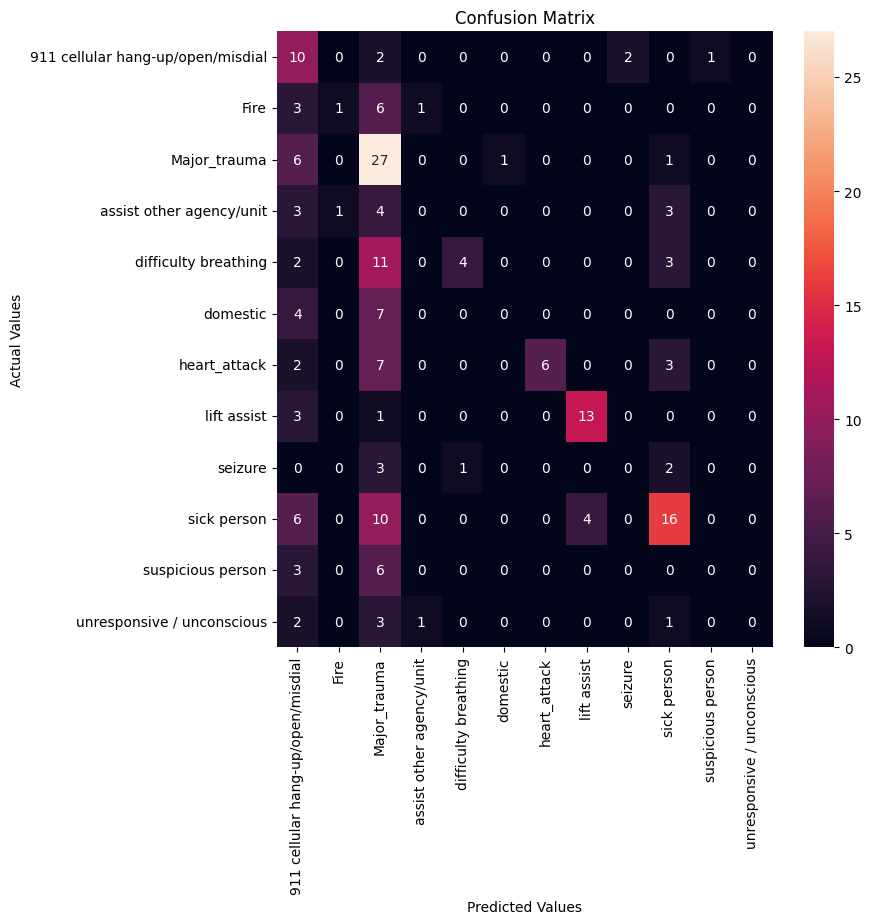

In [89]:
cm_before = confusion_matrix(y_test, preds_before)
cm_df_before = pd.DataFrame(cm_before,
                     index = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'], 
                     columns = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'])
plt.figure(figsize=(8,8))
sns.heatmap(cm_df_before, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [90]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

preds_nb_before = nb.predict(X_test)
print(classification_report(y_test, preds_nb_before))

                                   precision    recall  f1-score   support

911 cellular hang-up/open/misdial       1.00      0.20      0.33        15
                             Fire       0.00      0.00      0.00        11
                     Major_trauma       0.38      0.77      0.50        35
         assist other agency/unit       0.20      0.09      0.13        11
             difficulty breathing       0.80      0.20      0.32        20
                         domestic       0.43      0.27      0.33        11
                     heart_attack       0.75      0.33      0.46        18
                      lift assist       0.50      0.06      0.11        17
                          seizure       0.00      0.00      0.00         6
                      sick person       0.37      0.92      0.52        36
                suspicious person       0.00      0.00      0.00         9
       unresponsive / unconscious       0.50      0.14      0.22         7

                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


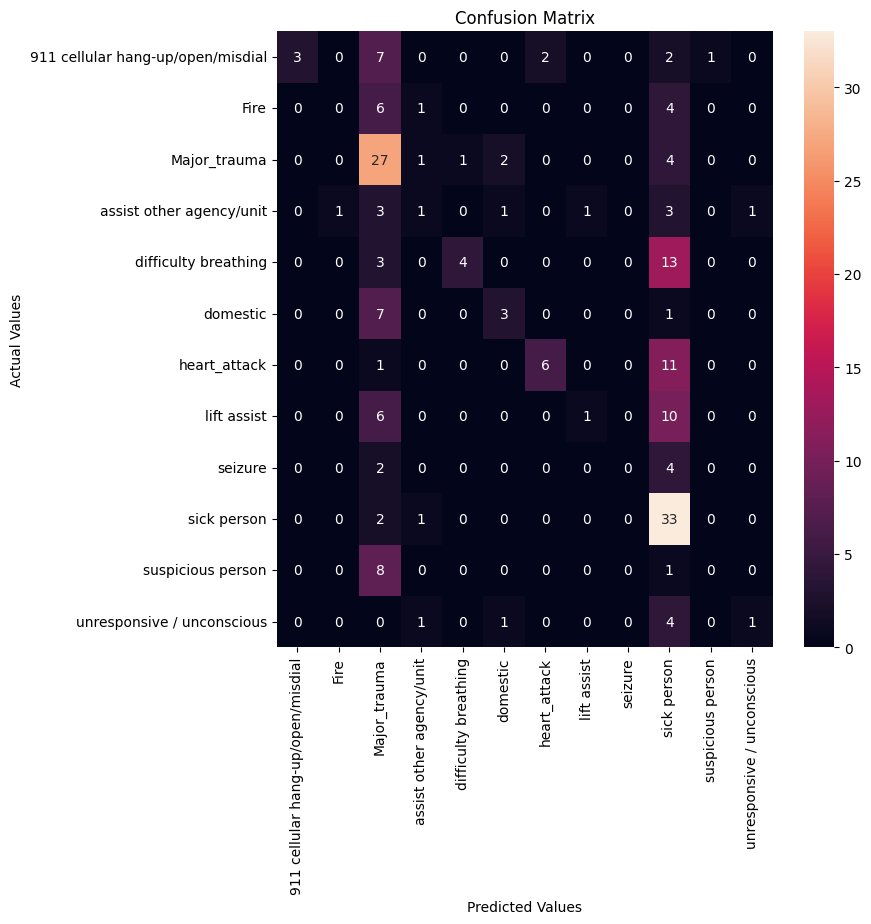

In [91]:
cm_before_nb = confusion_matrix(y_test, preds_nb_before)
cm_df_before_nb = pd.DataFrame(cm_before_nb,
                     index = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'], 
                     columns = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'])
plt.figure(figsize=(8,8))
sns.heatmap(cm_df_before_nb, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [92]:
from scipy.sparse import coo_matrix, hstack
X1 = vec.fit_transform(df_train.clean_text)
X_test1 = vec.transform(df_test.clean_text)
X2 = vec.fit_transform(df_train.key_words_disease)
X_test2 = vec.transform(df_test.key_words_disease)
X3 = vec.fit_transform(df_train.key_words_chemical)
X_test3 = vec.transform(df_test.key_words_chemical)
X_train = hstack([X1,X2,X3])
X_test = hstack([X_test1,X_test2,X_test3])

y_train = df_train.target
y_test = df_test.target

In [93]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

                                   precision    recall  f1-score   support

911 cellular hang-up/open/misdial       0.23      0.67      0.34        15
                             Fire       0.67      0.18      0.29        11
                     Major_trauma       0.33      0.80      0.46        35
         assist other agency/unit       0.00      0.00      0.00        11
             difficulty breathing       0.80      0.20      0.32        20
                         domestic       0.00      0.00      0.00        11
                     heart_attack       1.00      0.39      0.56        18
                      lift assist       0.72      0.76      0.74        17
                          seizure       0.00      0.00      0.00         6
                      sick person       0.59      0.44      0.51        36
                suspicious person       0.00      0.00      0.00         9
       unresponsive / unconscious       0.00      0.00      0.00         7

                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
preds

array(['sick person', '911 cellular hang-up/open/misdial', 'Major_trauma',
       '911 cellular hang-up/open/misdial', 'Major_trauma', 'Fire',
       'heart_attack', 'lift assist', 'assist other agency/unit',
       'Major_trauma', 'Major_trauma', 'lift assist', 'lift assist',
       'Major_trauma', 'Major_trauma', 'sick person', 'Major_trauma',
       '911 cellular hang-up/open/misdial', 'Major_trauma',
       'Major_trauma', 'lift assist', 'Major_trauma', 'seizure',
       'sick person', 'lift assist', '911 cellular hang-up/open/misdial',
       'sick person', 'lift assist', '911 cellular hang-up/open/misdial',
       'Major_trauma', '911 cellular hang-up/open/misdial',
       '911 cellular hang-up/open/misdial', 'lift assist', 'Major_trauma',
       'Major_trauma', '911 cellular hang-up/open/misdial',
       'Major_trauma', 'Major_trauma', 'Major_trauma',
       '911 cellular hang-up/open/misdial', 'Major_trauma',
       '911 cellular hang-up/open/misdial', 'Major_trauma', 'sick per

In [75]:
y_test

970                           sick person
1002                    suspicious person
655                  difficulty breathing
168     911 cellular hang-up/open/misdial
269                          Major_trauma
                      ...                
1328    911 cellular hang-up/open/misdial
1274                          lift assist
1052                         Major_trauma
1007                         Major_trauma
218                               seizure
Name: target, Length: 196, dtype: object

In [94]:
cm_after = confusion_matrix(y_test, preds)

In [95]:
cm_df = pd.DataFrame(cm_after,
                     index = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'], 
                     columns = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'])

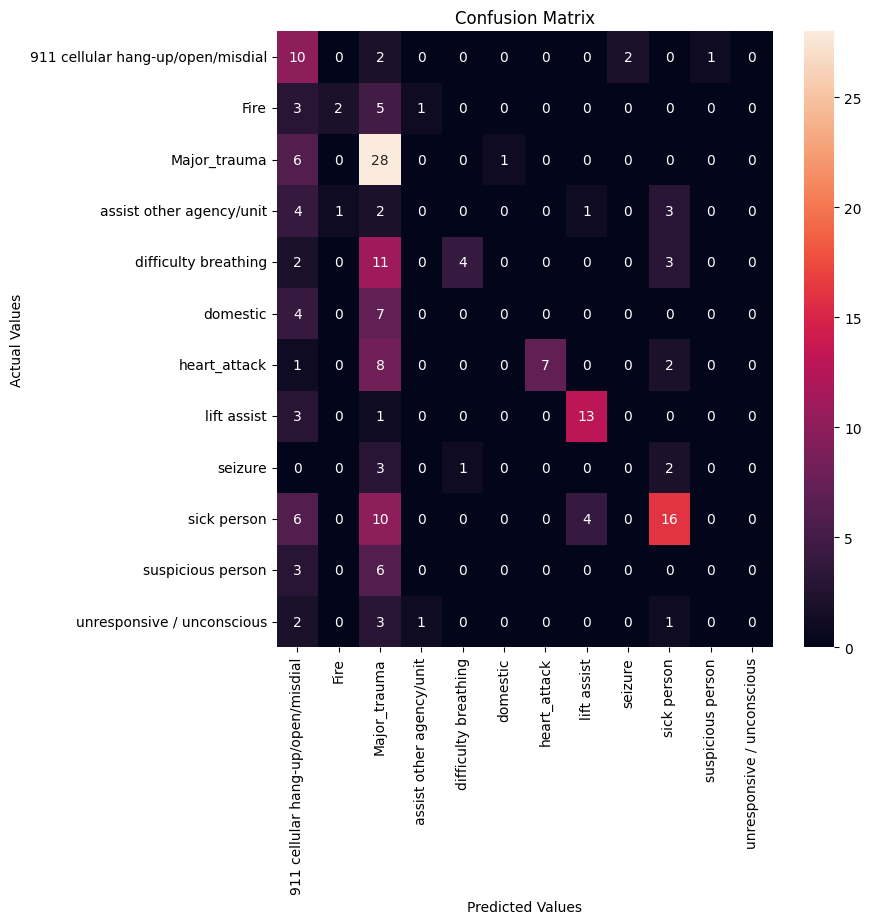

In [96]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [97]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

preds_nb_after = nb.predict(X_test)
print(classification_report(y_test, preds_nb_after))

                                   precision    recall  f1-score   support

911 cellular hang-up/open/misdial       1.00      0.07      0.12        15
                             Fire       0.50      0.09      0.15        11
                     Major_trauma       0.37      0.77      0.50        35
         assist other agency/unit       0.20      0.09      0.13        11
             difficulty breathing       0.83      0.25      0.38        20
                         domestic       0.33      0.18      0.24        11
                     heart_attack       0.78      0.39      0.52        18
                      lift assist       0.50      0.06      0.11        17
                          seizure       0.00      0.00      0.00         6
                      sick person       0.38      0.92      0.54        36
                suspicious person       0.00      0.00      0.00         9
       unresponsive / unconscious       0.50      0.14      0.22         7

                       

In [98]:
from sklearn.metrics import confusion_matrix
cm_after_nb = confusion_matrix(y_test, preds_nb_after)

In [99]:
cm_df_after_nb = pd.DataFrame(cm_after_nb,
                     index = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'], 
                     columns = ['911 cellular hang-up/open/misdial','Fire','Major_trauma','assist other agency/unit','difficulty breathing','domestic','heart_attack','lift assist','seizure','sick person','suspicious person','unresponsive / unconscious'])

In [100]:
import seaborn as sns

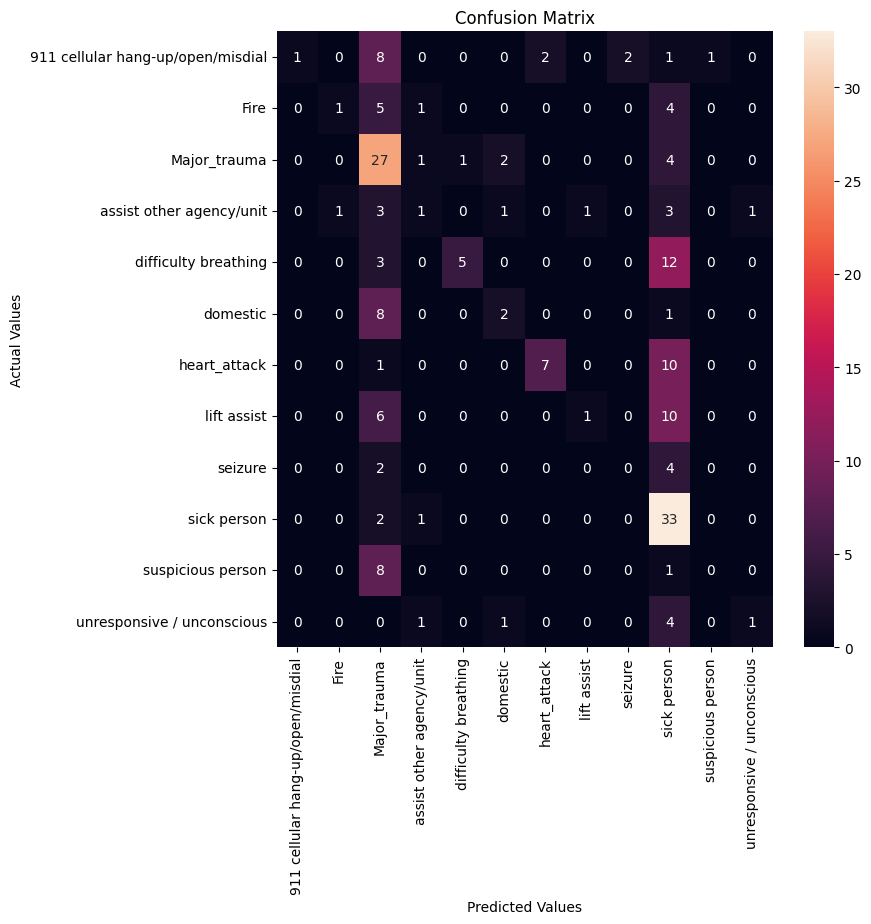

In [101]:
#Plotting the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm_df_after_nb, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()